In [21]:
######### IMPORT ###########
from collections import deque
import random
import pandas as pd  # package for some uses and maybe for visualization
import numpy as np
import heapq
from matplotlib.pylab import plot, show, bar
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import time as time1



In [22]:
df = pd.read_csv('arrival_rates.csv')
df  
floors_num = 25
arrival_rates_by_floor_section = [
    [18, 10.8, 40.8], [50, 6.8, 12.8], [11, 4.8, 7.8]]
arrival_rates = [
    [[], []],
    [[], [], []],
    [[], [], []]
]
k = -1
for i in range(3):
    for j in range(len(arrival_rates[i])):
        k += 1
        if k == 8:
            break
        opc = [df.loc[k, "other"], df.loc[k, "15--18"], df.loc[k, "7--10"]]
        arrival_rates[i][j].extend(opc)
arrival_rates[0].insert(0, None)
# Creating a dictionary with the range of each floor
# the range ressembles the location in the rate array
lower_floor_range = {floor: 1 for floor in range(1, 16)}
upper_floor_range = {floor: 2 for floor in range(16, 26)}
lower_floor_range.update(upper_floor_range)
floor_range = lower_floor_range
floor_range[0] = 0  # ground floor


In [23]:
######### CLASS ###########
class Event():
    def __init__(self, time, eventType, passenger=-1, elevator=-1):
        self.time = time  # event time
        self.eventType = eventType  # type of the event
        self.passenger = passenger
        self.elevator = elevator
        heapq.heappush(P, self)  # add the event to the events list

    def __lt__(self, event2):
        return self.time < event2.time

########################
#### Passenger class ###
########################


class Passenger(object):
    def __init__(self, start, end, arrival_time):
        self.id = passenger_count  # unique identifier
        self.start = start
        self.end = end
        self.arrival_time = arrival_time  # time of first arrival
        # self.current_floor = floor
        self.in_journey = (start != 0 and end != 0) and ((
            start > 15 and end <= 15) or (start <= 15 and end > 15))
        # self.journey_started = False  # describes the current part of the journey. Either 1 or 2
        self.left = False
        self.started_using_sys = False
        if self.in_journey:
            # in journey
            # always going down firt to floor 0
            self.direction = -1
        else:
            # not in journey
            if end > start:
                self.direction = 1
            else:
                self.direction = -1


class Elevator(object):
    def __init__(self, id, starting_floor, direction, top_floor):
        self.id = id
        self.curr_floor = starting_floor
        self.prev_floor = starting_floor
        self.stop_time = curr_time  # last stop time
        self.passengers = []
        self.max_capacity = 15
        self.remaining_space = self.max_capacity - len(self.passengers)
        self.direction = direction  # up / down
        self.is_top_elevator = top_floor == 25
        self.top_floor = top_floor
        if top_floor == 15:
            self.min_floor = 1  # lowest floor in section
        else:
            self.min_floor = 16  # lowest floor in section
        self.is_broken = False  # elevator starts un-broken
        self.last_broken_time = -1  # time of last break

    # Gets the elevator destination. Checks if it was broken until arriving
    def update_space(self):
        self.remaining_space = self.max_capacity - len(self.passengers)

    def move(self):
        self.prev_floor = self.curr_floor

        if self.is_top_elevator:
            if self.curr_floor == 16 and self.direction == -1:
                self.curr_floor -= 15  # move the elevator past sector #1
            elif self.curr_floor == 0 and self.direction == 1:
                self.curr_floor += 15  # move the elevator past sector #1
        self.curr_floor += self.direction
        if (self.curr_floor == 0 and self.direction) or (self.curr_floor in [15, 25] and self.direction == 1):
            # if reached end of section, flip direction
            self.direction *= -1

    def did_break(self):
        if self.is_broken:
            # it's now fixed after being broken
            self.is_broken = False
            return False
        else:
            # elevator has been working until now
            rnd = seed_2.random()
            
            if rnd < 0.0005:
                # and now it broke
                self.is_broken = True
                self.last_broken_time = curr_time
                return True
            else:
                # still not broken
                return False

    def switch_direction(self):
        self.direction *= -1

    # removes leaving passengers and returns journey passengers
    def release_passengers(self):
        # count the passengers just before they leave
        elevator_usage[self.id -
                       1][len(self.passengers)] += curr_time - self.stop_time
        elevator_usage_by_day[i][self.id -
                       1][len(self.passengers)] += curr_time - self.stop_time
        leaving_passengers = list(
            [p for p in self.passengers if self.curr_floor == p.end])  # for visualization
        for p in leaving_passengers:
            service_time.append(curr_time - p.arrival_time)
            service_time_by_day[i].append(curr_time - p.arrival_time)
        journey_passengers = []
        if self.curr_floor == 0:
            # journey passengers are saved in the system
            journey_passengers = list(
                [p for p in self.passengers if p.in_journey])
            self.passengers = list(
                [p for p in self.passengers if self.curr_floor != p.end and not p.in_journey])
        else:
            # create new passengers list with all the passengers that stay
            self.passengers = list(
                [p for p in self.passengers if self.curr_floor != p.end])

        return journey_passengers

     # removes passengers in the broken elevator to the other elevator
    def release_when_broken(self, direction):
        # count the passengers before they leave
        elevator_usage[self.id -
                       1][len(self.passengers)] += curr_time - self.stop_time
        elevator_usage_by_day[i][self.id -
                       1][len(self.passengers)] += curr_time - self.stop_time
        # release only passengers that go to the same direction as the rescue elevator
        released = list(
            [p for p in self.passengers if self.direction == direction])
        self.passengers = list(
            [p for p in self.passengers if self.curr_floor != p.end and not self.direction == direction])
        return released

######### FUNCTION ###########

## returns current rate ##
##########################


def get_current_rate_by_floor(start_floor, end_floor):
    # get current arrival rate according to start floor,
    # destination, (or section) and curr_time(which would be determined
    # at the start of each While iteration)
    start_floor_section = floor_range[start_floor]
    end_floor_section = floor_range[end_floor]
    if curr_time >= 60*60 and curr_time < 4*60*60:
        # 07:00-10:00
        hour_range = 2
    elif curr_time >= 9*60*60 and curr_time < 12*60*60:
        # 15:00-18:00
        hour_range = 1
    else:
        # any other time
        hour_range = 0

    rate = arrival_rates[start_floor_section][end_floor_section][hour_range]
    # Convert to exponential rate
    return (60*60)/rate

# return if morning rush hour


def is_morning():
    return curr_time >= 60*60 and curr_time < 4*60*60
    # 07:00-10:00

# return if evening rush hour


def is_evening():
    return curr_time >= 9*60*60 and curr_time < 12*60*60
    # 15:00-18:00


def get_travel_time(floors):
    start = 2
    stop = 2
    wait = 5
    pass_by = 1
    return floors * pass_by + start + stop + wait


#### Performance Measures ####
n = 5 # intervals
service_time = []  # for visualization - service time for each passenger
service_time_by_day = i = [ [] for _ in range(n) ]  # for visualization - service time for each passenger
avg_service = []  # for visualization - avg service duration
avg_out_of_patience = [0]*n  # out of patience per day
elevator_usage = [[0]*16, [0]*16, [0]*16, [0]*16]
elevator_usage_by_day = [ [[0]*16, [0]*16, [0]*16, [0]*16] for _ in range(n)]
##############################

start_time = time1.time()
for i in range(n):
    seed_1 = np.random.RandomState(i)
    seed_2 = np.random.RandomState(i+100)   
    ######### INITIATE ###########
    # initialize simulation
    curr_time = 0  # current time
    SIM_TIME = 14*60*60  # simulation time in minutes

    P = []  # heap
    L_up = [[] for _ in range(26)]  # going up line in every floor
    # at floor zero we have 2 seperate lines for the 2 pairs of elevator
    L_up[0] = [[], []]
    L_down = [[] for _ in range(26)]  # going down line in every floor
    passenger_count = 0

    # create list of elevators
    elevators = [Elevator(id=1, starting_floor=0, direction=1, top_floor=15), Elevator(id=2, starting_floor=20, direction=1, top_floor=25), Elevator(
        id=3, starting_floor=0, direction=1, top_floor=25), Elevator(id=4, starting_floor=25, direction=-1, top_floor=25)]

    for start in range(0, 26):
        for end in range(0, 26):
            if start == end:
                continue
            time = seed_1.exponential(get_current_rate_by_floor(start, end))
            new_passenger = Passenger(start, end, time)
            passenger_count += 1
            Event(time, "arriving", passenger=new_passenger)

    for elevator in elevators:
        # init elevators
        Event(curr_time + 5, "elevator_close", elevator=elevator)

    ######### LOOP ###########
    while curr_time < SIM_TIME:  # loop until sim time ends
        # print(passenger_count)

        event = heapq.heappop(P)  # get next event
        curr_time = event.time  # current event's time

        ## arriving ##
        if event.eventType == "arriving":
            passenger = event.passenger
            # insert passenger to floor line
            if passenger.direction == 1:
                if passenger.start == 0:
                    # passenger is going up on floor zero
                    heapq.heappush(
                        L_up[0][1 if passenger.end > 15 else 0], (passenger.arrival_time, id(passenger), passenger))
                else:
                    heapq.heappush(
                        L_up[passenger.start], (passenger.arrival_time, id(passenger), passenger))
            else:
                heapq.heappush(L_down[passenger.start],
                               (passenger.arrival_time, id(passenger), passenger))
            # check if he will be out of patience
            Event(curr_time + 15*60, "out_of_patience", passenger)
            # generate next passenger
            rate = get_current_rate_by_floor(passenger.start, passenger.end)
            new_time = curr_time + seed_1.exponential(rate)
            new_passenger = Passenger(passenger.start, passenger.end, new_time)
            passenger_count += 1
            Event(new_time, "arriving", passenger=new_passenger)
            ##############

        ## elevator_close ##
        elif event.eventType == "elevator_close":
            elevator = event.elevator

            is_broken = elevator.did_break()
            # passengers with this destination are free to go, returns journey passengers in floor 0
            journey_passengers = elevator.release_passengers()
            if elevator.curr_floor == 0:
                # if in floor 0, add journey passengers to queue
                for j_passenger in journey_passengers:
                    # add journey passengers back to the line
                    # they always go up if in middle of journey
                    j_passenger.in_journey = False
                    j_passenger.direction = 1
                    heapq.heappush(L_up[0][1 if j_passenger.end > 15 else 0],
                                   (curr_time - 5, id(j_passenger), j_passenger))
            # pull passengers from broken elevator
            for other_elevator in elevators:
                if other_elevator != elevator and other_elevator.top_floor == elevator.top_floor:
                    if other_elevator.is_broken and other_elevator.curr_floor == elevator.curr_floor and other_elevator.direction == elevator.direction:
                        # other elevator is stuck right now on same floor and with same direction
                        # and also the current elevator didnt break
                        # therefore we will take any passenger we can with us
                        released_from_broken = other_elevator.release_when_broken(
                            elevator.direction)
                        # add another counting point for passengers leaving to another elevator
                        other_elevator.stop_time = curr_time
                        for p in released_from_broken:
                            elevator.update_space()
                            if elevator.remaining_space > 0:
                                # both are going in the same direction
                                # passenger enters the elevator
                                # appends randomly
                                elevator.passengers.append(p)
                            else:
                                # return these passengers back to home elevator
                                other_elevator.passengers.append(p)

            if is_broken:
                # handle elevator broken
                fix_time = curr_time + seed_2.uniform(5, 15)*60
                Event(fix_time, "elevator_close", elevator=elevator)
                # if elevator is stuck, it won't be moving
            else:  # not stuck
                if elevator.direction == 1:  # list of customers in line
                    if elevator.curr_floor == 0:  # if floor is zero - we have 2 seperate up lines
                        waiting_passengers = L_up[0][1 if elevator.is_top_elevator else 0]
                    else:
                        waiting_passengers = L_up[elevator.curr_floor]
                else:
                    waiting_passengers = L_down[elevator.curr_floor]
                while waiting_passengers:
                    elevator.update_space()
                    if elevator.remaining_space > 0:
                        # both are going in the same direction
                        # passenger enters the elevator
                        # returns the passenger from tuple

                        next_in_line = heapq.heappop(waiting_passengers)[2]
                        # passengers started using the elevators and wont run out of patience
                        next_in_line.started_using_sys = True
                        elevator.passengers.append(next_in_line)
                    else:
                        break  # stop inserting passengers to elevator, no room or no more passengers
                elevator.stop_time = curr_time
                if (elevator.curr_floor == 16 and elevator.direction == -1) or (elevator.curr_floor == 0 and elevator.direction == 1 and elevator.is_top_elevator):
                    next_time = curr_time + get_travel_time(floors=16)
                else:
                    next_time = curr_time + get_travel_time(floors=1)
                # if not broken, move as scheduled to next floor

                if is_evening() and ((elevator.id == 2 and elevator.curr_floor == 0) or (elevator.id == 3 and elevator.curr_floor == 0)):
                    elevator.direction = -1
                    elevator.curr_floor = 25
                    next_time = curr_time + get_travel_time(floors=25)
                    Event(next_time, "elevator_close", elevator=elevator)

                elif is_morning() and ((elevator.id == 2 and elevator.curr_floor == 25) or (elevator.id == 3 and elevator.curr_floor == 25)):
                    elevator.direction = 1
                    elevator.curr_floor = 0
                    next_time = curr_time + get_travel_time(floors=25)
                    Event(next_time, "elevator_close", elevator=elevator)
                    
                else:
                    Event(next_time, "elevator_close", elevator=elevator)
                    elevator.move()  # moves elevator to next floor + open + close doors

        ## out_of_patience ##
        elif event.eventType == "out_of_patience":
            passenger = event.passenger
            if passenger.left is False and passenger.started_using_sys is False:
                # print("out of patience at: " + str(curr_time))
                passenger.left = True
                # will always be next passenger
                if passenger.direction == 1:
                    if passenger.start == 0:
                        for p_tuple in L_up[0][1 if passenger.end > 15 else 0]:
                            if p_tuple[2] == passenger:
                                L_up[0][1 if passenger.end >
                                        15 else 0].remove(p_tuple)
                        heapq.heapify(L_up[passenger.start][1 if passenger.end >
                                                            15 else 0])
                    else:
                        for p_tuple in L_up[passenger.start]:
                            if p_tuple[2] == passenger:
                                L_up[passenger.start].remove(p_tuple)
                        heapq.heapify(L_up[passenger.start])
                else:
                    for p_tuple in L_down[passenger.start]:
                        if p_tuple[2] == passenger:
                            L_down[passenger.start].remove(p_tuple)
                    heapq.heapify(L_down[passenger.start])
                avg_out_of_patience[i] += 1  # for visualization
                service_time.append(curr_time - passenger.arrival_time)
                #service_time_by_day[i].append(curr_time - passenger.arrival_time)
    ##############

end_time = time1.time()
print(end_time - start_time)

7.230994701385498


In [24]:
cummulative_day = []
for day in service_time_by_day:
    cummulative_day.append(sum(day) / len(day))

print(cummulative_day)

[239.76679636598203, 243.00114934416527, 232.38974407522696, 253.32430381153353, 233.16664634600255]


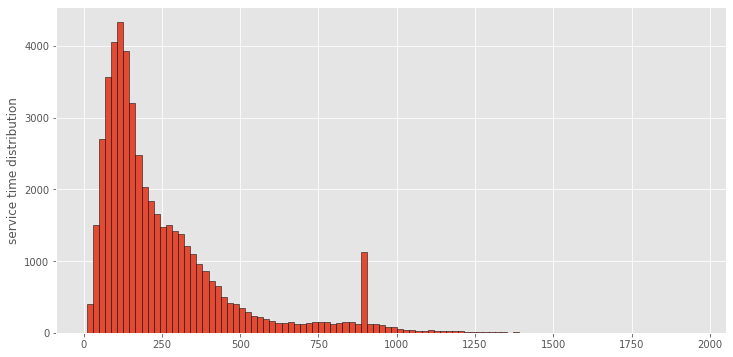

In [25]:
########  FIRST

#lypo = np.array(service_time)
#print(sorted(service_time,reverse=True))

#print(sorted(service_time,reverse=True)[0:-3])
#lypo = pd.Series(sorted(service_time)[0:-3])

lypo = pd.Series(service_time)

fig = lypo.hist(bins = 100,edgecolor='k',figsize=(12,6)).set_ylabel("service time distribution")

#lypo.plot.hist(bins=60, edgecolor='k').autoscale(enable=True, axis='both', tight=True)
#skt1 = pd.cut(service_time,200).value_counts()
#print(skt1)
#skt1.hist()

In [26]:
### Average of out of patience passengers ###
needed_average = sum(avg_out_of_patience)/len(avg_out_of_patience)
print("Average of out of patience passengers: ", avg_out_of_patience , needed_average)


Average of out of patience passengers:  [248, 229, 178, 176, 154] 197.0


[2496.7615010477857, 2540.0, 3050.0, 3020.0, 3410.0, 3490.0, 3730.0, 3730.0, 3650.0000000000036, 3957.620424893874, 3030.0, 2440.0, 2560.0, 2440.0, 1790.0, 5090.0]
8476.761501047786


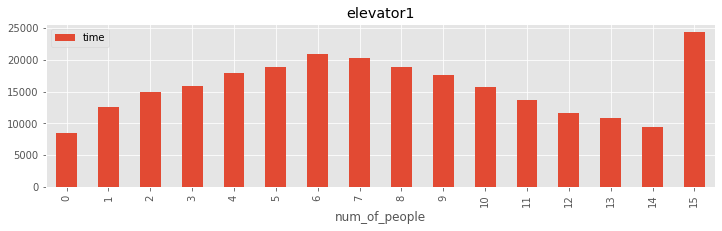

In [27]:
### התפלגות תפוסת המעליות ###
mat1 = []
mat2 = []
mat3 = []
mat4 = []

for i in range(16):
    mat1.append([i,elevator_usage[0][i]]) 

for i in range(16):
    mat2.append([i,elevator_usage[1][i]])

for i in range(16):
    mat3.append([i,elevator_usage[2][i]]) 

for i in range(16):
    mat4.append([i,elevator_usage[3][i]]) 
df1 = pd.DataFrame(mat1, columns=["num_of_people", "time"]) # hold the data in a pandas Data Frame object
title='elevator1'
df1.plot.bar(x="num_of_people", y="time",figsize=(12,3), title=title); #bar plot 
print(elevator_usage_by_day[0][0])
print(elevator_usage[0][0])




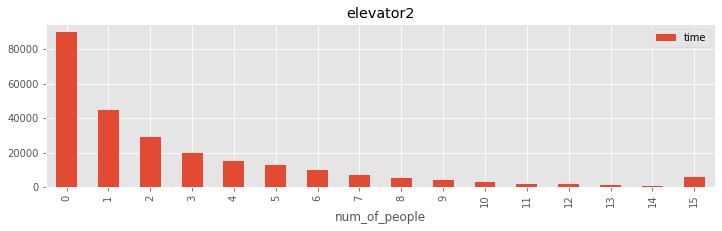

In [28]:
df2 = pd.DataFrame(mat2, columns=["num_of_people", "time"]) # hold the data in a pandas Data Frame object
title='elevator2'
df2.plot.bar(x="num_of_people", y="time",figsize=(12,3), title=title); #bar plot 


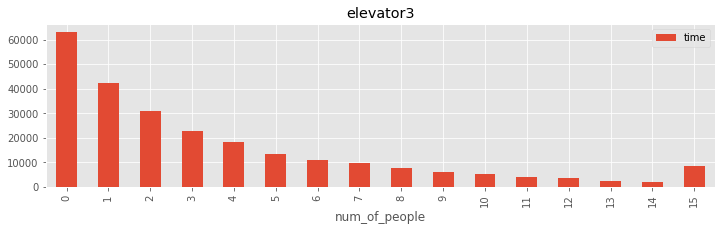

In [29]:
df3 = pd.DataFrame(mat3, columns=["num_of_people", "time"]) # hold the data in a pandas Data Frame object
title='elevator3'
df3.plot.bar(x="num_of_people", y="time",figsize=(12,3), title=title); #bar plot 


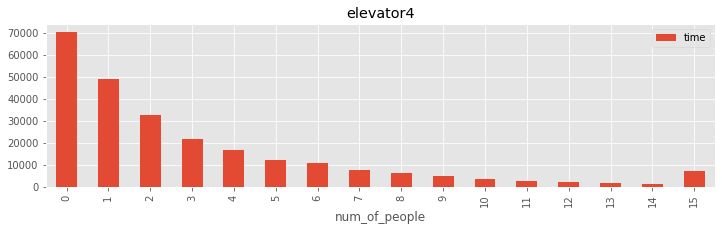

In [30]:
df4 = pd.DataFrame(mat4, columns=["num_of_people", "time"]) # hold the data in a pandas Data Frame object
title='elevator4'
df4.plot.bar(x="num_of_people", y="time",figsize=(12,3), title=title); #bar plot 
